**TDI Capstone Project**


## Scraping

### Scraping: IMSDB

In [ ]:
import requests
import pickle
from bs4 import BeautifulSoup

We first get the response from [imsdb.com](https://imsdb.com/all-scripts.html), and go to the page where all the transcripts are listed:

In [ ]:

response=requests.get("https://imsdb.com/all-scripts.html")
print(response.url)

response.text[:500] + "..."


We soupify the response

In [ ]:
soup = BeautifulSoup(response.text)
print(soup.prettify())

We look for the parent object where script links can be parsed from

In [ ]:
parent = soup.find_all('td', attrs={'valign': 'top'}) #Find (at most) *one*
parent=parent[2]
parent

In [ ]:
#Total number of the transcripts

scripts = parent.find_all('p', attrs={})  #Find *all*
len(scripts)
print("The total number of the transcripts on this page is {}. ".format(len(scripts)))

In [ ]:
# We can see how the list looks like

n=10
print("First {} Movies are: \n".format(n))

def shortlist(num):
    for i in range(num):
        print(i+1,scripts[i].text)
shortlist(n)

In [ ]:
#parsing the href link and the movie_name
"""
mov -> soup element has the info for the given movie
mov[0]['href'] -> href tag
mov[0].text -> Movie name
"""

mov=scripts[12].find_all('a',href=True)
print("\n soup= {} \n\n href= {} \n\n name= {}".format(mov,mov[0]['href'],mov[0].text))

In [ ]:
#We pass the the href tag from the
"""
We pass the href tag we obtained from allscripts page
as an argument for the url where the transcript of the movie
lives.
"""
mov_response=requests.get("https://imsdb.com/"+mov[0]['href'])
print(mov_response.url)
mov_response.text[:1000] + "..."

In [ ]:
mov_soup=BeautifulSoup(mov_response.text)
parent2 = mov_soup.find_all('td', attrs={'valign': 'top'})
script_text_link=parent2[2].find_all('a',href=True)[-1]['href']
script_text_link

In [ ]:
scr_response=requests.get("https://imsdb.com/"+script_text_link)
print(scr_response.url)
scr_response.text[:1000] + "..."

In [ ]:
scr_soup=BeautifulSoup(scr_response.text)
title_of_movie=mov[0].text #title of the movie
script_of_movie=scr_soup.find_all('pre')#script ofthe movie
script_of_movie

In [ ]:
import os

def parse_to_txt(i,title_of_movie,script_of_movie):
    
    """
    Takes the (title,script) of the movie as an argument and
    parses it into a .txt file in folder_path.
    
    """
    file_name=title_of_movie
    folder_path="/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts"
    index=str(i)
    
    with open(index+" "+file_name+'.txt', 'a') as output:
        output.write(script_of_movie)

parse_to_txt(i,title_of_movie,script_of_movie)

### Scraping (Clean): IMSDB

In [Scraping](Scraping)

 * Lets put all of the above into a single function that:

     - Starts from the all-scripts page.
     - Finds the page where scrips lives
     - Parses it into a .txt file

In [ ]:
#IMSDB Scraper
import requests
import pickle
from bs4 import BeautifulSoup
import os

response=requests.get("https://imsdb.com/all-scripts.html")
soup = BeautifulSoup(response.text)
parent = soup.find_all('td', attrs={'valign': 'top'}) 
parent=parent[2] #parent soup where scripts are listed

scripts = parent.find_all('p', attrs={})


def parse_to_txt(i,title_of_movie,script_of_movie):
    
    """
    Takes the (title,script) of the movie as an argument and
    parses it into a .txt file in folder_path.
    
    """
    file_name=title_of_movie
    folder_path="/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts"
    index=str(i)
    
    with open(index+" "+file_name+'.txt', 'a') as output:
        output.write(script_of_movie)

def parse_movie_script(i):
    """
    Scraping
    """
    mov=scripts[i].find_all('a',href=True)
    mov_response=requests.get("https://imsdb.com/"+mov[0]['href'])
    
    mov_soup=BeautifulSoup(mov_response.text)
    parent2 = mov_soup.find_all('td', attrs={'valign': 'top'})
    script_text_link=parent2[2].find_all('a',href=True)[-1]['href']
    
    scr_response=requests.get("https://imsdb.com/"+script_text_link)
    scr_soup=BeautifulSoup(scr_response.text)
    
    title_of_movie=mov[0].text #title of the movie
    script_of_movie=scr_soup.find_all('pre')[0].text #script ofthe movie
    
    parse_to_txt(i,title_of_movie,script_of_movie)
   

l=len(scripts)
for i in range(l):
    try:
        parse_movie_script(i)
    except:
        print("Index={}".format(i))
    


    
    

We want to start building the dataframe from the transcripts

In [ ]:
#Parsing the transcript names into a dataframe

import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
mypath='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts'
scripts = [f for f in listdir(mypath) if isfile(join(mypath, f))]

#below is to make sure all files were .txt
#mypath='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts'
#onlyfiles=[f for f in listdir(mypath) if isfile(join(mypath, f)) if f[-3:]=='txt']

def clean(x):
    """
    Just to clean the names a bit
    """
    str=x.strip('.txt')
    if str[-3:]=='The':
        return ' '.join(['The']+str.split(' ')[1:-1]).strip(',')
    else:
        str=' '.join(str.split(' ')[1:])
        return str

d={'Movie Name':scripts}
df=pd.DataFrame(data=d)
df['Movie Name']=df['Movie Name'].apply(clean)
df.head(5)





We pickle the result into the dataframe `df`

In [ ]:
pickle.dump(df,open( "df.p", "wb" ) )

We can check how it looks like:

In [10]:
df=pickle.load( open( "df.p", "rb" ))
df.head(5)

,Movie Name
0,The Lord of the Rings: Fellowship of the Ring
1,Lost Horizon
2,War Horse
3,The Italian Job
4,Thor


#### Comment

It didn't parse 75 movies. I'm just going to ignore this portion.

In [ ]:
#Movies that are not scraped
#The code in the docstring gives the indices of the movies that were not scraped.

"""
res='Index=12Index=20Index=29Index=84Index=122Index=123Index=142Index=143Index=144Index=145Index=162Index=192Index=193Index=208Index=239Index=244Index=247Index=271Index=277Index=286Index=291Index=292Index=317Index=355Index=375Index=383Index=395Index=398Index=447Index=449Index=464Index=473Index=487Index=519Index=520Index=521Index=522Index=523Index=524Index=561Index=582Index=590Index=613Index=635Index=638Index=645Index=675Index=676Index=688Index=733Index=741Index=774Index=782Index=796Index=823Index=830Index=839Index=843Index=927Index=932Index=942Index=971Index=1005Index=1020Index=1034Index=1056Index=1081Index=1122Index=1137Index=1143Index=1147Index=1149Index=1168Index=1171Index=1179'
res=res.split('Index=')
res.remove(res[0])
res=[int(res) for res in res]
pickle.dump(res,open( "res.p", "wb" ) )
#len(res)



pickle.load( open( "res.p", "rb" ))
for err in res:
    print(err)
"""


    


### Scraping: IMDB

In [ ]:

imdb_url='https://www.imdb.com/search/title/?title='
movie_url='Joker'
url=imdb_url+movie_url
response=requests.get(url)
print(response.url)

response.text[:500] + "..."


In [ ]:
soup = BeautifulSoup(response.text)
soup.prettify

In [ ]:
parent = soup.find_all('div', attrs={'class': 'lister-list'})
list=parent[0].find_all('div', attrs={'class': 'lister-item mode-advanced'})
len(list)

It's a 30 item list of movies for the given querry as movie_name. Then we look at the topmost item and parse the href.

In [ ]:
list[0].find_all('h3')[0].find_all('a',href=True)[0]['href']

* We want to parse 3 items
    - Score
    - Year
    - Genre tags
    

In [ ]:
mov_url=list[0].find_all('h3')[0].find_all('a',href=True)[0]['href']
imdb_url='https://www.imdb.com'
url=imdb_url+mov_url
response=requests.get(url)
print(response.url)

response.text[:500] + "..."

In [ ]:
#parsing year and score
soup=BeautifulSoup(response.text)
mov_score=soup.find_all('span', attrs={'class': 'sc-7ab21ed2-1 jGRxWM'})[0].text #score
mov_year=soup.find_all('span',attrs={'class':'sc-8c396aa2-2 itZqyK'})[0].text #year
mov_year,mov_score


In [ ]:
#parsing genres
gen_soup=soup.find_all('div',attrs={'class':'ipc-chip-list sc-16ede01-4 bMBIRz'})
gen_soup=gen_soup[0].find_all('a',attrs={'class':"sc-16ede01-3 bYNgQ ipc-chip ipc-chip--on-baseAlt"})
mov_genres=[]
for gen in gen_soup:
    mov_genres.append(gen.text)


### Scraping  (Clean): IMDB

In [16]:
#IMDB Scraper
import requests
import pickle
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np


my_dict = {"Movie Name":[],"Year":[],"Score":[],"Genre":[]};


def imdb_parser(movie_url='Joker'):
    
    imdb_url='https://www.imdb.com/search/title/?title='
    url=imdb_url+movie_url
    response=requests.get(url)
    soup = BeautifulSoup(response.text)
    
    parent = soup.find_all('div', attrs={'class': 'lister-list'})
    m_list=parent[0].find_all('div', attrs={'class': 'lister-item mode-advanced'})
    mov_url=m_list[0].find_all('h3')[0].find_all('a',href=True)[0]['href']
    
    imdb_url='https://www.imdb.com'
    url=imdb_url+mov_url
    response=requests.get(url)
    soup=BeautifulSoup(response.text)
    
    mov_score=soup.find_all('span', attrs={'class': 'sc-7ab21ed2-1 jGRxWM'})[0].text #score
    mov_year=soup.find_all('span',attrs={'class':'sc-8c396aa2-2 itZqyK'})[0].text #year
    
    gen_soup=soup.find_all('div',attrs={'class':'ipc-chip-list sc-16ede01-4 bMBIRz'})#genre tags
    gen_soup=gen_soup[0].find_all('a',attrs={'class':"sc-16ede01-3 bYNgQ ipc-chip ipc-chip--on-baseAlt"})
    mov_genres=[]
    for gen in gen_soup:
        mov_genres.append(gen.text)
        
    my_dict["Movie Name"].append(movie_url)
    my_dict["Year"].append(mov_year)
    my_dict["Score"].append(mov_score)
    my_dict["Genre"].append(mov_genres)
       
    print(movie_url,mov_score,mov_year,mov_genres)

imdb_parser(df['Movie Name'][1])

#Run the code in docstring
#to scrape all movies
#and parse it into my_dict
    
"""
for movie in df['Movie Name']:
    try:
        imdb_parser(movie)
    except:
        my_dict["Movie Name"].append(movie_url)
        my_dict["Year"].append(np.nan)
        my_dict["Score"].append(np.nan)
        my_dict["Genre"].append(np.nan)
"""

print("Done")

IndexError: list index out of range

In [ ]:
df['Movie Name'][7]

In [ ]:
df_imdb=pd.DataFrame(data=my_dict)

In [ ]:
df_imdb.info()

We lost 130 movies on the first scraping of imdb, and another 60 while cleaning the year column.

In [ ]:
pickle.dump(df_imdb,open( "df_imdb.p", "wb" ) )

In [ ]:
df_imdb=pickle.load( open( "df_imdb.p", "rb" ))
df2=df_imdb.set_index('Movie Name')
df2.info()

In [ ]:
df3=df2.loc[df2['Year'].str.len()==4]
df3

In [ ]:
pickle.dump(df3,open( "df3.p", "wb" ) )

In [ ]:
pickle.load( open( "df3.p", "rb" ))
df3.info()

In [ ]:
df3.head(5)

In [ ]:
#onlyfiles has 1137 movies, we have clean data for 920
mypath='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts'
onlyfiles=[f for f in listdir(mypath) if isfile(join(mypath, f)) if f[-3:]=='txt']
onlyfiles[0]

## Constructing the Feature Matrix

In [17]:
import pickle
df_imdb=pickle.load( open( "df_imdb.p", "rb" ))
df2=df_imdb.set_index('Movie Name')

df3=df2.loc[df2['Year'].str.len()==4]#cleaning a parsing issue on Year

df4 = df3.reset_index()
df4

,Movie Name,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,1982,7.7,"[Action, Adventure, Sci-Fi]"
...,...,...,...,...
915,The Social Network,2010,7.8,"[Biography, Drama]"
916,The White Ribbon,2009,7.8,"[Drama, Mystery, Thriller]"
917,Wild Hogs,2007,5.8,"[Action, Adventure, Comedy]"
918,The Change-Up,2011,6.3,"[Comedy, Fantasy]"


In [19]:
df4['Movie Name'][0]

'The Lord of the Rings: Fellowship of the Ring'

In [356]:
#The reason for this function is some mismatch inbetween scraping/parsings
import os

def clean(x):
    """
    Just to clean the names a bit
    """
    str=x.strip('.txt')
    if str[-3:]=='The':
        return ' '.join(['The']+str.split(' ')[1:-1]).strip(',')
    else:
        str=' '.join(str.split(' ')[1:])
        return str

def find_file_name(movie_name):
    """
    Takes the movie name from df4 as input, and
    gives the transcript file name from dir as output
    """

    my_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts/'
    keyword = movie_name
    for fname in os.listdir(my_path):
        if keyword.lower() in clean(fname).lower():
             return(fname)
#find_file_name(df4['Movie Name'][0])

find_file_name(df4['Movie Name'][96])

'486 Good Will Hunting.txt'

In [24]:
"""
I want to clean this script line by line to get words
to get the raw scores we can  use "".join(script_text_cleaned)

"""
import re
from nrclex import NRCLex
import nltk

def preprocess_file(movie_name):
    """
    1) Takes the movie_name as input from dataframe
    2) Applies preprocessing
        *reads lines
        *removes empty lines
        *lines->list of words
        *nltk stemming
    3) Returns the transcript file as as a list of lines of clean word lists.
    
    """
    my_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts/'
    file_name=find_file_name(movie_name)

    with open(my_path+file_name, 'r') as file:
            script_text = file.read().split("\n")

    #incrased memory, but bypasses a bug for owerriting within for loop
    #lowercasing,splitting into words       
    script_text_clean=[]
    for line in script_text:
        script_text_clean.append(re.sub("[^\w]", " ", line.lower()).split())

    script_text_clean=[vec for vec in script_text_clean if vec!=[]]# cleans empty lines

    #stopwords
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    script_text_clean=[[w for w in line if not w.lower() in stop_words] for line in script_text_clean ]

    return script_text_clean

preprocess_file(df4['Movie Name'][0])[:20]

[['black', 'screen'],
 ['super', 'new', 'line', 'cinema', 'presents'],
 ['super', 'wingnut', 'films', 'production'],
 ['black', 'continues', 'elvish', 'singing', 'woman', 'voice'],
 ['whispering', 'tinged', 'sadness', 'regret'],
 ['galadriel', 'v'],
 ['elvish', 'subtitled'],
 ['amar', 'prestar', 'sen', 'han', 'mathon', 'ne', 'nen'],
 ['han', 'mathon', 'ne', 'chae', 'han', 'noston', 'ned'],
 ['wilith'],
 ['english'],
 ['world', 'changed', 'feel'],
 ['water', 'feel', 'earth', 'smell'],
 ['air', 'much', 'lost'],
 ['none', 'live', 'remember'],
 ['super', 'lord', 'rings'],
 ['ext', 'prologue', 'day'],
 ['image', 'flickering', 'firelight', 'noldorin', 'forge', 'eregion'],
 ['molten', 'gold', 'pours', 'lip', 'iron', 'ladle'],
 ['galadriel', 'v']]

In [33]:
import itertools

def get_emotions_portion(transcript,begin=None,end=200):
    """
    1)Takes the preprocessed file as input
    2)Performs NRCLex on the portion of it
    3)Returns the emotion vector as output
    """
    transcript_portion=transcript[begin:end]

    flat_ls = list(itertools.chain(*transcript_portion))
    flat_ls=" ".join(flat_ls)

    file_text_object=NRCLex(flat_ls)

    emotion_vec = file_text_object.raw_emotion_scores
    
    return emotion_vec
transcript=preprocess_file(df4['Movie Name'][0])
get_emotions_portion(transcript)

{'negative': 77,
 'sadness': 38,
 'anticipation': 18,
 'positive': 34,
 'trust': 23,
 'anger': 25,
 'disgust': 21,
 'joy': 12,
 'surprise': 8,
 'fear': 30}

In [34]:
#transcript=preprocess_file(movie_name)

def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict
    
movie_name=df4['Movie Name'][0]

transcript=preprocess_file(movie_name)
sentiment_evolution(transcript)

{'anger': [33, 21, 20, 31, 32, 39, 28, 34, 28, 71, 43, 41],
 'negative': [107, 53, 78, 70, 88, 104, 65, 71, 85, 124, 92, 81],
 'trust': [48, 47, 28, 49, 37, 37, 57, 34, 37, 29, 68, 32],
 'anticipation': [53, 51, 26, 27, 33, 22, 42, 47, 33, 44, 54, 34],
 'joy': [48, 60, 18, 44, 44, 29, 39, 24, 29, 19, 58, 31],
 'positive': [84, 90, 57, 88, 73, 80, 82, 71, 75, 65, 110, 69],
 'fear': [40, 36, 45, 43, 51, 62, 48, 43, 69, 92, 59, 46],
 'sadness': [52, 20, 44, 35, 29, 40, 26, 27, 44, 47, 52, 48],
 'surprise': [35, 44, 15, 23, 27, 19, 28, 17, 22, 31, 31, 33],
 'disgust': [28, 13, 17, 22, 20, 33, 21, 18, 29, 38, 29, 25]}

In [28]:
#construct a dictionary from this array for the given movie
#merge those dictionaries
#create a dataframe
#merge data frames
#s_dict={}

from nrclex import NRCLex
import nltk
import pandas as pd

def flatten(sentiments):
    flattened_scores=[]
    for emotion in sentiments:
        flattened_scores+=sentiments[emotion]
        #len(flattened_scores)
    return flattened_scores

def movie_to_sentiments(movie_name):
    """
    Takes movie_name as input
    returns dataframe row with sentiment scores.
    """

    transcript=preprocess_file(movie_name)#preprocessing

    res=sentiment_evolution(transcript)#get sentiment arrays

    flattened_scores=flatten(res)#flattening sentiment scores

    movie_dict={'Movie Name':movie_name}
    for j in range(120):
        movie_dict.update({'s_{}'.format(j):flattened_scores[j]})
   
    
    return  pd.DataFrame([movie_dict])

movie_name=df4['Movie Name'][0]

movie_to_sentiments(movie_name)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,17,22,20,33,21,18,29,38,29,25


In [34]:
#constructing the matrix
#spits out names of movies where there is an indexing issue
df = pd.DataFrame({})#empty dataframe
for i in range(920):
    movie_name=df4['Movie Name'][i]
    try:
        temp_df=movie_to_sentiments(movie_name)
        df=pd.concat([df,temp_df], ignore_index = True, axis = 0)
    except:
        print(movie_name)

Conan the Barbarian
The Neverending Story
Chronicles of Narnia: The Lion, the Witch and the Wardrobe
Omega Man
The Miracle Worker
Frankenweenie
Scary Movie 2
Frankenstein
This is 40
American Outlaws
Walking Tall
Chronicle
Apollo 13
The Beach
Les Tontons Flingueurs
Jeux Interdits
Cube
Training Day
Edward Scissorhands
Pokemon: Mewtwo Returns
Chaos
eXistenZ


In [36]:
df.head(10)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,17,22,20,33,21,18,29,38,29,25
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,24,23,15,16,11,16,11,16,27,19
2,War Horse,24,30,22,22,24,31,19,36,68,...,30,16,23,15,15,17,24,28,13,17
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,23,33,26,29,24,16,17,20,29,16
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,16,8,7,13,14,12,11,12,21,13
5,Boogie Nights,16,17,14,9,35,20,35,18,20,...,10,10,17,10,17,13,20,30,16,20
6,The Last Station,15,16,18,15,15,14,24,22,15,...,15,11,21,14,18,12,16,11,9,12
7,Barton Fink,18,30,32,9,16,23,20,17,27,...,21,20,18,18,19,16,26,8,13,22
8,Cradle 2 the Grave,22,19,23,33,29,19,26,28,36,...,10,15,22,14,19,7,10,9,9,8
9,Django Unchained,75,64,100,77,62,47,52,51,41,...,77,42,52,33,40,33,24,39,36,53


In [37]:
pickle.dump(df,open( "df_movies.p", "wb" ) )

In [40]:
df_movies=pickle.load( open( "df_movies.p", "rb" ))
df_movies.head(10)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,17,22,20,33,21,18,29,38,29,25
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,24,23,15,16,11,16,11,16,27,19
2,War Horse,24,30,22,22,24,31,19,36,68,...,30,16,23,15,15,17,24,28,13,17
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,23,33,26,29,24,16,17,20,29,16
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,16,8,7,13,14,12,11,12,21,13
5,Boogie Nights,16,17,14,9,35,20,35,18,20,...,10,10,17,10,17,13,20,30,16,20
6,The Last Station,15,16,18,15,15,14,24,22,15,...,15,11,21,14,18,12,16,11,9,12
7,Barton Fink,18,30,32,9,16,23,20,17,27,...,21,20,18,18,19,16,26,8,13,22
8,Cradle 2 the Grave,22,19,23,33,29,19,26,28,36,...,10,15,22,14,19,7,10,9,9,8
9,Django Unchained,75,64,100,77,62,47,52,51,41,...,77,42,52,33,40,33,24,39,36,53


In [67]:
#Finally our full feature matrix
df_movies=pickle.load( open( "df_movies.p", "rb" ))
df_movies.head(10)

df_final=pd.merge(df_movies,df4,on='Movie Name')
df=df_final
df.head(5)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_113,s_114,s_115,s_116,s_117,s_118,s_119,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,33,21,18,29,38,29,25,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,16,11,16,11,16,27,19,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,24,30,22,22,24,31,19,36,68,...,15,15,17,24,28,13,17,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,29,24,16,17,20,29,16,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,13,14,12,11,12,21,13,1982,7.7,"[Action, Adventure, Sci-Fi]"


In [68]:
#Movies with issues.
"""
Conan the Barbarian
The Neverending Story
Chronicles of Narnia: The Lion, the Witch and the Wardrobe
Omega Man
The Miracle Worker
Frankenweenie
Scary Movie 2
Frankenstein
This is 40
American Outlaws
Walking Tall
Chronicle
Apollo 13
The Beach
Les Tontons Flingueurs
Jeux Interdits
Cube
Training Day
Edward Scissorhands
Pokemon: Mewtwo Returns
Chaos
eXistenZ
"""

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Columns: 124 entries, Movie Name to Genre
dtypes: int64(120), object(4)
memory usage: 878.9+ KB


## Construction (Clean)

In [27]:
#imports
import os
import pickle
import re
from nrclex import NRCLex
import nltk
import itertools
import pandas as pd
import numpy as np

In [32]:
#functions

def clean(x):
    """
    Just to clean the names a bit
    """
    str=x.strip('.txt')
    if str[-3:]=='The':
        return ' '.join(['The']+str.split(' ')[1:-1]).strip(',')
    else:
        str=' '.join(str.split(' ')[1:])
        return str

def find_file_name(movie_name):
    """
    Takes the movie name from df4 as input, and
    gives the transcript file name from dir as output
    """

    my_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts/'
    keyword = movie_name
    for fname in os.listdir(my_path):
        if keyword.lower() in clean(fname).lower():
             return(fname)
            
def preprocess_file(movie_name):
    """
    1) Takes the movie_name as input from dataframe
    2) Applies preprocessing
        *reads lines
        *removes empty lines
        *lines->list of words
        *nltk stemming
    3) Returns the transcript file as as a list of lines of clean word lists.
    
    """
    my_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/Transcripts/'
    file_name=find_file_name(movie_name)

    with open(my_path+file_name, 'r') as file:
            script_text = file.read().split("\n")

    #incrased memory, but bypasses a bug for owerriting within for loop
    #lowercasing,splitting into words       
    script_text_clean=[]
    for line in script_text:
        script_text_clean.append(re.sub("[^\w]", " ", line.lower()).split())

    script_text_clean=[vec for vec in script_text_clean if vec!=[]]# cleans empty lines

    #stopwords
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    script_text_clean=[[w for w in line if not w.lower() in stop_words] for line in script_text_clean ]

    return script_text_clean

def get_emotions_portion(transcript,begin=None,end=200):
    """
    1)Takes the preprocessed file as input
    2)Performs NRCLex on the portion of it
    3)Returns the emotion vector as output
    """
    transcript_portion=transcript[begin:end]

    flat_ls = list(itertools.chain(*transcript_portion))
    flat_ls=" ".join(flat_ls)

    file_text_object=NRCLex(flat_ls)

    emotion_vec = file_text_object.raw_emotion_scores
    
    return emotion_vec

def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict

def flatten(sentiments):
    flattened_scores=[]
    for emotion in sentiments:
        flattened_scores+=sentiments[emotion]
        #len(flattened_scores)
    return flattened_scores

def movie_to_sentiments(movie_name):
    """
    Takes movie_name as input
    returns dataframe row with sentiment scores.
    """

    transcript=preprocess_file(movie_name)#preprocessing

    res=sentiment_evolution(transcript)#get sentiment arrays

    flattened_scores=flatten(res)#flattening sentiment scores

    movie_dict={'Movie Name':movie_name}
    for j in range(120):
        movie_dict.update({'s_{}'.format(j):flattened_scores[j]})
   
    
    return  pd.DataFrame([movie_dict])


In [406]:
#imdb parsed-> df4 (dataframe)
df_imdb=pickle.load( open( "df_imdb.p", "rb" ))
df2=df_imdb.set_index('Movie Name')

df3=df2.loc[df2['Year'].str.len()==4]#cleaning a parsing issue on Year

df4 = df3.reset_index()
df4

,Movie Name,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,1982,7.7,"[Action, Adventure, Sci-Fi]"
...,...,...,...,...
915,The Social Network,2010,7.8,"[Biography, Drama]"
916,The White Ribbon,2009,7.8,"[Drama, Mystery, Thriller]"
917,Wild Hogs,2007,5.8,"[Action, Adventure, Comedy]"
918,The Change-Up,2011,6.3,"[Comedy, Fantasy]"


In [408]:
df4['Movie Name'][494]

'Joker'

In [236]:
#Finally our full feature matrix
df_movies=pickle.load( open( "df_movies.p", "rb" ))
df_movies.head(10)

df_final=pd.merge(df_movies,df4,on='Movie Name')
df=df_final
df.head(5)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_113,s_114,s_115,s_116,s_117,s_118,s_119,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,33,21,18,29,38,29,25,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,16,11,16,11,16,27,19,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,24,30,22,22,24,31,19,36,68,...,15,15,17,24,28,13,17,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,29,24,16,17,20,29,16,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,13,14,12,11,12,21,13,1982,7.7,"[Action, Adventure, Sci-Fi]"


## Visualization

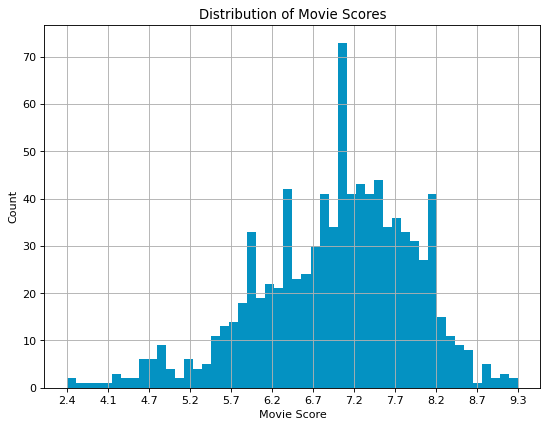

In [447]:
#Distribution of scores
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
y_plot=df['Score'].sort_values()
plt.hist(y_plot,bins=50,color='#0492c2')
plt.grid(True)
plt.xticks(np.arange(0, 60, step=5))  # Set label locations.
plt.title('Distribution of Movie Scores')
plt.xlabel('Movie Score')
plt.ylabel('Count')

plt.draw()
plt.savefig('{}/score_distribution.png'.format(img_path), bbox_inches='tight')

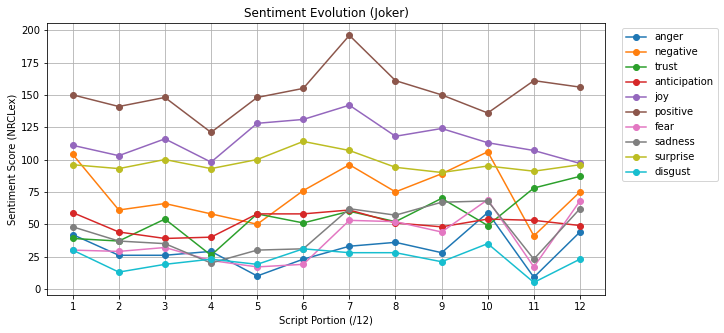

In [448]:
#Sentiment evolution plot
from matplotlib.pyplot import figure
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict

def visualize_sentiment_evolution(movie_name):
    """
    Takes movie name as input
    plots sentiment evolution as output
    """

    transcript=preprocess_file(movie_name)
    sentiment_dict=sentiment_evolution(transcript)
    
    x_coordinates = [1,2,3,4,5,6,7,8,9,10,11,12]

    #sentiment_dict
    for emotion in sentiment_dict:
        plt.plot(x_coordinates, sentiment_dict[emotion],marker='o',label=emotion)

    plt.xticks(np.arange(1, 13, step=1))
    plt.legend(bbox_to_anchor=(1.21, 1), loc='upper right', ncol=1)

    plt.title("Sentiment Evolution ({})".format(movie_name))
    plt.ylabel('Sentiment Score (NRCLex)')
    plt.xlabel('Script Portion (/12)')
    plt.grid(visible=True)
    return plt.draw()

movie_name=df['Movie Name'][484]
visualize_sentiment_evolution(movie_name)
img_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/img'
plt.savefig('{}/{}_evolution.png'.format(img_path,movie_name), bbox_inches='tight')

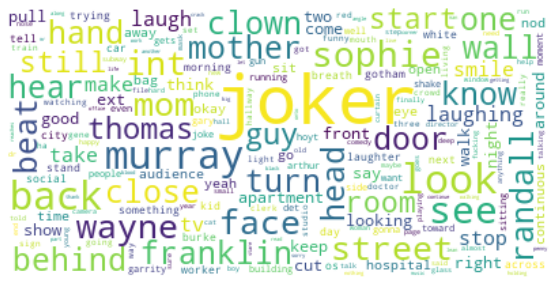

In [449]:
# Create and generate a word cloud image:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools

def visualize_wordcloud(movie_name):

    transcript=preprocess_file(movie_name)
    flat_ls = list(itertools.chain(*transcript))
    flat_ls=" ".join(flat_ls)

    wordcloud = WordCloud(background_color='white',
                          max_font_size = 50,
                          collocations=False).generate(flat_ls)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.draw()

movie_name=df['Movie Name'][484]
visualize_wordcloud(movie_name)
img_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/img'
plt.savefig('{}/{}_wordcloud.png'.format(img_path,movie_name), bbox_inches='tight')

## ML

In [226]:
#Our complete feature matrix
#From the pickled files
import pickle
import pandas as pd

df_imdb=pickle.load( open( "df_imdb.p", "rb" ))
df2=df_imdb.set_index('Movie Name')
df3=df2.loc[df2['Year'].str.len()==4]#cleaning a parsing issue on Year
df4 = df3.reset_index()

df_movies=pickle.load( open( "df_movies.p", "rb" ))
df_movies.head(10)

df_final=pd.merge(df_movies,df4,on='Movie Name')
df=df_final
df.head(5)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_113,s_114,s_115,s_116,s_117,s_118,s_119,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,33,21,18,29,38,29,25,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,16,11,16,11,16,27,19,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,24,30,22,22,24,31,19,36,68,...,15,15,17,24,28,13,17,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,29,24,16,17,20,29,16,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,13,14,12,11,12,21,13,1982,7.7,"[Action, Adventure, Sci-Fi]"


In [2]:
#checking for empty cells
df.isna().any()

Movie Name    False
s_0           False
s_1           False
s_2           False
s_3           False
              ...  
s_118         False
s_119         False
Year          False
Score         False
Genre         False
Length: 124, dtype: bool

In [4]:
#Our feature matrix
X=df.drop(['Score','Year','Genre','Movie Name'],axis=1)#defining the feature matrix
X.head(2)

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,33,21,20,31,32,39,28,34,28,71,...,17,22,20,33,21,18,29,38,29,25
1,60,36,73,76,37,53,40,45,38,34,...,24,23,15,16,11,16,11,16,27,19


In [28]:
#best model so far
#RandomForest -> max_depth:3 ,R^2=0.01
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


X=df.drop(['Score','Year','Genre','Movie Name'],axis=1)#defining the feature matrix
y=df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#train/test split

#est = DecisionTreeRegressor()
est=RandomForestRegressor()

gs_final = GridSearchCV(
    est,
    {"max_depth": range(1,11)},  
    cv=10, 
    n_jobs=2, 
)
gs_final.fit(X_train, y_train);

print("The best hyperparameter value is: ", gs_final.best_params_)  

The best hyperparameter value is:  {'max_depth': 3}


In [29]:
r2_score_on_test = gs_final.score(X_test, y_test)
print('R^2 score of the test data set equals: {0:.3f}'.format(r2_score_on_test))

R^2 score of the test data set equals: 0.011


## Discussion

We wanted to know the strength of 'sentiment evolution' as a metric to measure the success of a movie. We tested this on 900 titles we scraped from IMDB/IMSDB. In the first approach we see that our model has  

$$ R^2_{model}=0.011\approx 0 $$

which we interpret as the bulk of our feature matrix being the sentiment evolution scores of the transcript, does not explain the variability of the response data around its mean. 

We can improve the model by including the additional categorial features "genre" and "year". However any improvement of the model is not going to change the fact that "sentiment evolution" of a transcript is not a successful metric for predicting the score of the corresponding movie.  




## Cumulative Analysis

Below is the analysis for the total sentiment scores of the transcript

In [244]:
df.head()

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_113,s_114,s_115,s_116,s_117,s_118,s_119,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,33,21,20,31,32,39,28,34,28,...,33,21,18,29,38,29,25,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,60,36,73,76,37,53,40,45,38,...,16,11,16,11,16,27,19,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,24,30,22,22,24,31,19,36,68,...,15,15,17,24,28,13,17,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,24,32,27,35,28,33,32,28,28,...,29,24,16,17,20,29,16,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,24,21,21,10,14,23,25,18,21,...,13,14,12,11,12,21,13,1982,7.7,"[Action, Adventure, Sci-Fi]"


In [265]:
#transcript=preprocess_file(movie_name)

def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict
    
def sentiment_cum(movie_name):
    transcript=preprocess_file(movie_name)
    sd=sentiment_evolution(transcript)
    
    for emotion in sd:
        sd[emotion]=np.array(sd[emotion]).cumsum()
    return sd

movie_name=df['Movie Name'][0]
sentiment_cum(movie_name)
    

{'anger': array([ 33,  54,  74, 105, 137, 176, 204, 238, 266, 337, 380, 421]),
 'negative': array([ 107,  160,  238,  308,  396,  500,  565,  636,  721,  845,  937,
        1018]),
 'trust': array([ 48,  95, 123, 172, 209, 246, 303, 337, 374, 403, 471, 503]),
 'anticipation': array([ 53, 104, 130, 157, 190, 212, 254, 301, 334, 378, 432, 466]),
 'joy': array([ 48, 108, 126, 170, 214, 243, 282, 306, 335, 354, 412, 443]),
 'positive': array([ 84, 174, 231, 319, 392, 472, 554, 625, 700, 765, 875, 944]),
 'fear': array([ 40,  76, 121, 164, 215, 277, 325, 368, 437, 529, 588, 634]),
 'sadness': array([ 52,  72, 116, 151, 180, 220, 246, 273, 317, 364, 416, 464]),
 'surprise': array([ 35,  79,  94, 117, 144, 163, 191, 208, 230, 261, 292, 325]),
 'disgust': array([ 28,  41,  58,  80, 100, 133, 154, 172, 201, 239, 268, 293])}

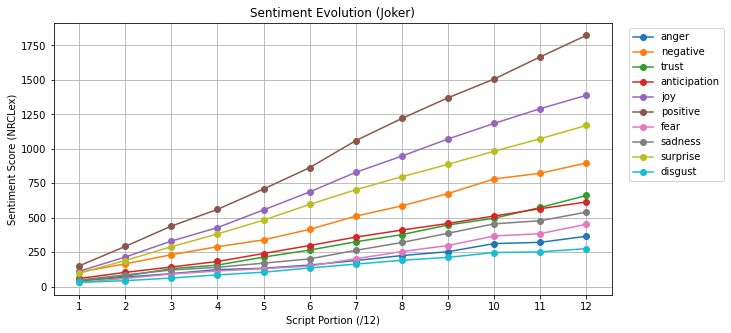

In [424]:
def visualize_sentiment_cum(movie_name):
    """
    Takes movie name as input
    plots sentiment evolution as output
    """
    sentiment_dict=sentiment_cum(movie_name)
    
    x_coordinates = [1,2,3,4,5,6,7,8,9,10,11,12]

    #sentiment_dict
    for emotion in sentiment_dict:
            plt.plot(x_coordinates, sentiment_dict[emotion],marker='o',label=emotion)

    plt.xticks(np.arange(1, 13, step=1))
    plt.legend(bbox_to_anchor=(1.21, 1), loc='upper right', ncol=1)

    plt.title("Sentiment Evolution ({})".format(movie_name))
    plt.ylabel('Sentiment Score (NRCLex)')
    plt.xlabel('Script Portion (/12)')
    plt.grid(visible=True)
    return plt.draw()
movie_name=df['Movie Name'][484]
visualize_sentiment_cum(movie_name)
plt.savefig('{}/{}_total_sentiment.pdf'.format(img_path,movie_name), bbox_inches='tight')

In [270]:
#construct a dictionary from this array for the given movie
#merge those dictionaries
#create a dataframe
#merge data frames
#s_dict={}

from nrclex import NRCLex
import nltk
import pandas as pd

def flatten(sentiments):
    flattened_scores=[]
    for emotion in sentiments:
        flattened_scores+=sentiments[emotion]
        #len(flattened_scores)
    return flattened_scores

def movie_to_sentiments_cum(movie_name):
    """
    Takes movie_name as input
    returns dataframe row with sentiment scores.
    """

    res=sentiment_cum(movie_name)#get sentiment arrays
    for em in res:
        res[em]=res[em].tolist()

    flattened_scores=flatten(res)#flattening sentiment scores

    movie_dict={'Movie Name':movie_name}
    for j in range(120):
        movie_dict.update({'s_{}'.format(j):flattened_scores[j]})
   
    
    return  pd.DataFrame([movie_dict])

movie_name=df['Movie Name'][0]

movie_to_sentiments_cum(movie_name)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,The Lord of the Rings: Fellowship of the Ring,33,54,74,105,137,176,204,238,266,...,58,80,100,133,154,172,201,239,268,293


In [ ]:
#constructing the matrix
#spits out names of movies where there is an indexing issue
df_cum = pd.DataFrame({})#empty dataframe
for i in range(920):
    movie_name=df['Movie Name'][i]
    try:
        temp_df=movie_to_sentiments_cum(movie_name)
        df_cum=pd.concat([df_cum,temp_df], ignore_index = True, axis = 0)
    except:
        print(movie_name)

In [276]:
pickle.dump(df_cum,open( "df_cum.p", "wb" ) )

In [277]:
df_cum=pickle.load( open( "df_cum.p", "rb" ))
df_cum.head(10)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_110,s_111,s_112,s_113,s_114,s_115,s_116,s_117,s_118,s_119
0,The Lord of the Rings: Fellowship of the Ring,33,54,74,105,137,176,204,238,266,...,58,80,100,133,154,172,201,239,268,293
1,Lost Horizon,60,96,169,245,282,335,375,420,458,...,58,81,96,112,123,139,150,166,193,212
2,War Horse,24,54,76,98,122,153,172,208,276,...,85,101,124,139,154,171,195,223,236,253
3,The Italian Job,24,56,83,118,146,179,211,239,267,...,94,127,153,182,206,222,239,259,288,304
4,Star Trek II: The Wrath of Khan,24,45,66,76,90,113,138,156,177,...,42,50,57,70,84,96,107,119,140,153
5,Boogie Nights,16,33,47,56,91,111,146,164,184,...,31,41,58,68,85,98,118,148,164,184
6,The Last Station,15,31,49,64,79,93,117,139,154,...,38,49,70,84,102,114,130,141,150,162
7,Barton Fink,18,48,80,89,105,128,148,165,192,...,71,91,109,127,146,162,188,196,209,231
8,Cradle 2 the Grave,22,41,64,97,126,145,171,199,235,...,42,57,79,93,112,119,129,138,147,155
9,Django Unchained,75,139,239,316,378,425,477,528,569,...,172,214,266,299,339,372,396,435,471,524


In [278]:
#Our complete feature matrix
#From the pickled files
import pickle
import pandas as pd

df_imdb=pickle.load( open( "df_imdb.p", "rb" ))
df2=df_imdb.set_index('Movie Name')
df3=df2.loc[df2['Year'].str.len()==4]#cleaning a parsing issue on Year
df4 = df3.reset_index()

df_cum=pickle.load( open( "df_cum.p", "rb" ))
df_cum.head(10)

df_final_cum=pd.merge(df_cum,df4,on='Movie Name')
df_cum=df_final_cum
df_cum.head(5)

,Movie Name,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_113,s_114,s_115,s_116,s_117,s_118,s_119,Year,Score,Genre
0,The Lord of the Rings: Fellowship of the Ring,33,54,74,105,137,176,204,238,266,...,133,154,172,201,239,268,293,2001,8.8,"[Action, Adventure, Drama]"
1,Lost Horizon,60,96,169,245,282,335,375,420,458,...,112,123,139,150,166,193,212,1937,7.6,"[Adventure, Drama, Fantasy]"
2,War Horse,24,54,76,98,122,153,172,208,276,...,139,154,171,195,223,236,253,2011,7.2,"[Action, Adventure, Drama]"
3,The Italian Job,24,56,83,118,146,179,211,239,267,...,182,206,222,239,259,288,304,2003,7.0,"[Action, Crime, Thriller]"
4,Star Trek II: The Wrath of Khan,24,45,66,76,90,113,138,156,177,...,70,84,96,107,119,140,153,1982,7.7,"[Action, Adventure, Sci-Fi]"


In [279]:
#best model so far
#RandomForest -> max_depth:2 ,R^2=0.038
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


X=df_cum.drop(['Score','Year','Genre','Movie Name'],axis=1)#defining the feature matrix
y=df_cum['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#train/test split

#est = DecisionTreeRegressor()
est=RandomForestRegressor()

gs_final = GridSearchCV(
    est,
    {"max_depth": range(1,11)},  
    cv=10, 
    n_jobs=2, 
)
gs_final.fit(X_train, y_train);

print("The best hyperparameter value is: ", gs_final.best_params_)  

The best hyperparameter value is:  {'max_depth': 2}


In [280]:
r2_score_on_test = gs_final.score(X_test, y_test)
print('R^2 score of the test data set equals: {0:.3f}'.format(r2_score_on_test))

R^2 score of the test data set equals: 0.038


In [286]:
#getting total sentiment scores for a movie
def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict
    
def sentiment_cum(movie_name):
    transcript=preprocess_file(movie_name)
    sd=sentiment_evolution(transcript)
    
    for emotion in sd:
        sd[emotion]=np.array(sd[emotion]).cumsum()
    return sd

def get_total_sentiment(movie_name):
    total_dict={'Movie Name':movie_name}
    sd=sentiment_cum(movie_name)
    for emotion in sd:
        total_dict.update({emotion:sd[emotion].tolist()[-1]})
       
    return pd.DataFrame([total_dict])

movie_name=df['Movie Name'][0]
get_total_sentiment(movie_name)

,Movie Name,anger,negative,trust,anticipation,joy,positive,fear,sadness,surprise,disgust
0,The Lord of the Rings: Fellowship of the Ring,421,1018,503,466,443,944,634,464,325,293


In [300]:
#convoluted, but might be useful for future modifications
#gets a list of total sentiment scores from a movie
movie_name=df['Movie Name'][0]
dfm=get_total_sentiment(movie_name)
dfm.loc[0][1:].tolist()

[421, 1018, 503, 466, 443, 944, 634, 464, 325, 293]

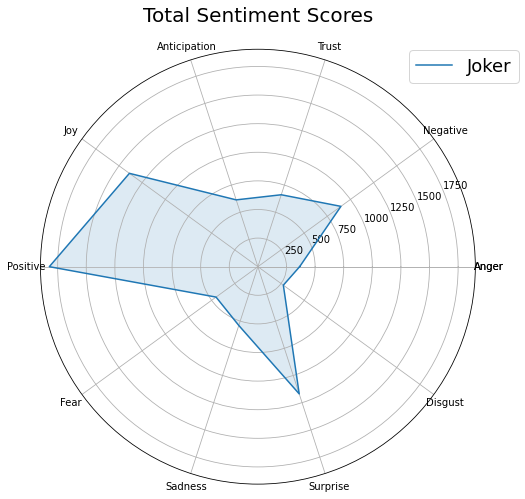

In [440]:
#movie_name -> radar_chart
def get_radar_chart(movie_name):
    labels=['Anger', 
              'Negative',
              'Trust', 
              'Anticipation',
              'Joy',
              'Positive',
              'Fear',
              'Sadness',
              'Surprise',
              'Disgust']

    labels = [*labels, labels[0]]

    dfm=get_total_sentiment(movie_name)

    movie_scores = dfm.loc[0][1:].tolist()
    #restaurant_2 = [5, 5, 4, 5, 2]

    movie_scores = [*movie_scores, movie_scores[0]]
    #restaurant_2 = [*restaurant_2, restaurant_2[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(movie_scores))


    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    plt.fill(label_loc, movie_scores, alpha=0.15)
    plt.plot(label_loc, movie_scores, label=movie_name)
    #plt.plot(label_loc, restaurant_2, label='Restaurant 2')
    plt.title('Total Sentiment Scores', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels)
    plt.legend(bbox_to_anchor=(1.12,0.96), loc='center right', ncol=1,prop={'size': 18})
    
    return plt.draw()
movie_name=df['Movie Name'][484]
get_radar_chart(movie_name)
plt.savefig('{}/{}_radar.pdf'.format(img_path,movie_name), bbox_inches='tight')

## Visualization (Clean)

In [444]:
# Create and generate a word cloud image:
"""
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

def sentiment_evolution(transcript):
    """
    Takes the cleaned transcript file as input
    returns the sentiment evolution for each 12 portion.
    
    """
    q=12#number of portions we look to describe the evolution
    l=len(transcript)
    p=int((l-l%q)/q)#gets rid of a couple of lines from the end

    emotion_dict={'anger':[], 
                  'negative': [], 
                  'trust': [], 
                  'anticipation': [], 
                  'joy': [], 
                  'positive': [], 
                  'fear': [], 
                  'sadness': [], 
                  'surprise': [], 
                  'disgust': []}
    
    for i in range(q):
        file_data=get_emotions_portion(transcript,i*p,(i+1)*p)
        for emotion in file_data:
            emotion_dict[emotion].append(file_data[emotion])
        
    
    return emotion_dict

def visualize_sentiment_evolution(movie_name):
    """
    Takes movie name as input
    plots sentiment evolution as output
    """

    transcript=preprocess_file(movie_name)
    sentiment_dict=sentiment_evolution(transcript)
    
    x_coordinates = [1,2,3,4,5,6,7,8,9,10,11,12]

    #sentiment_dict
    for emotion in sentiment_dict:
        plt.plot(x_coordinates, sentiment_dict[emotion],marker='o',label=emotion)

    plt.xticks(np.arange(1, 13, step=1))
    plt.legend(bbox_to_anchor=(1.21, 1), loc='upper right', ncol=1)

    plt.title("Sentiment Evolution ({})".format(movie_name))
    plt.ylabel('Sentiment Score (NRCLex)')
    plt.xlabel('Script Portion (/12)')
    plt.grid(visible=True)
    return plt.draw()

movie_name=df['Movie Name'][484]
visualize_sentiment_evolution(movie_name)
img_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/img'
plt.savefig('{}/{}_evolution.pdf'.format(img_path,movie_name), bbox_inches='tight')

def get_radar_chart(movie_name):
    labels=['Anger', 
              'Negative',
              'Trust', 
              'Anticipation',
              'Joy',
              'Positive',
              'Fear',
              'Sadness',
              'Surprise',
              'Disgust']

    labels = [*labels, labels[0]]

    dfm=get_total_sentiment(movie_name)

    movie_scores = dfm.loc[0][1:].tolist()
    #restaurant_2 = [5, 5, 4, 5, 2]

    movie_scores = [*movie_scores, movie_scores[0]]
    #restaurant_2 = [*restaurant_2, restaurant_2[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(movie_scores))


    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    plt.fill(label_loc, movie_scores, alpha=0.15)
    plt.plot(label_loc, movie_scores, label=movie_name)
    #plt.plot(label_loc, restaurant_2, label='Restaurant 2')
    plt.title('Total Sentiment Scores', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels)
    plt.legend(bbox_to_anchor=(1.12,0.96), loc='center right', ncol=1,prop={'size': 18})
    
    return plt.draw()
movie_name=df['Movie Name'][484]
get_radar_chart(movie_name)
plt.savefig('{}/{}_radar.pdf'.format(img_path,movie_name), bbox_inches='tight')

def visualize_sentiment_cum(movie_name):
    """
    Takes movie name as input
    plots sentiment evolution as output
    """
    sentiment_dict=sentiment_cum(movie_name)
    
    x_coordinates = [1,2,3,4,5,6,7,8,9,10,11,12]

    #sentiment_dict
    for emotion in sentiment_dict:
            plt.plot(x_coordinates, sentiment_dict[emotion],marker='o',label=emotion)

    plt.xticks(np.arange(1, 13, step=1))
    plt.legend(bbox_to_anchor=(1.21, 1), loc='upper right', ncol=1)

    plt.title("Sentiment Evolution ({})".format(movie_name))
    plt.ylabel('Sentiment Score (NRCLex)')
    plt.xlabel('Script Portion (/12)')
    plt.grid(visible=True)
    return plt.draw()
movie_name=df['Movie Name'][484]
visualize_sentiment_cum(movie_name)
plt.savefig('{}/{}_total_sentiment.pdf'.format(img_path,movie_name), bbox_inches='tight')


def visualize_wordcloud(movie_name):

    transcript=preprocess_file(movie_name)
    flat_ls = list(itertools.chain(*transcript))
    flat_ls=" ".join(flat_ls)

    wordcloud = WordCloud(background_color='white',
                          max_font_size = 50,
                          collocations=False).generate(flat_ls)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return plt.draw()

movie_name=df['Movie Name'][484]
visualize_wordcloud(movie_name)
img_path='/Users/candost.akkaya/Documents/TDI/TDI_Capstone/img'
plt.savefig('{}/{}_wordcloud.pdf'.format(img_path,movie_name), bbox_inches='tight')
"""


IndentationError: unexpected indent (2706559399.py, line 14)